## Denoise Validation


In [2]:
import os
import huggingface_hub

# Download the small checkpoint from HuggingFace
model_path = huggingface_hub.hf_hub_download("jkobject/scPRINT", "small.ckpt")

In [3]:
#! lamin init --storage ./lamin-intro --schema bionty 

import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor
import numpy as np
import anndata as ad

from scprint.tasks import Denoiser, withknn
from scdataloader.utils import downsample_profile
from scipy.stats import spearmanr
from anndata import AnnData
%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')

→ connected lamindb: jkobject/scprint


In [3]:
model_path

'/home/ml4ig1/.cache/huggingface/hub/models--jkobject--scPRINT/snapshots/c1e1f3d864b1d214fc61b4c95552c82ffe57211f/small.ckpt'

In [11]:
# model = scPrint.load_from_checkpoint('../../data/tensorboard/scprint_test/urxxwu28/checkpoints/epoch=0-step=20000.ckpt') #chocolate-surf-8
# '../../data/main/gene_embeddings.parquet')
model = scPrint.load_from_checkpoint(
    model_path, precpt_gene_emb=None)
    #'../../data/temp/last.ckpt', precpt_gene_emb=None)
    #transformer="normal")

# ../../data/temp/epoch=4-step=12500.ckpt latest model maestro (fortuitous laugther)
# ../../data/logs/scprint_test/f4vao230/checkpoints/epoch=10-step=27500.ckpt looked good as a training run (vermlillion noodle)
# d1792z9k/epoch=3-step=10000.ckpt
# '../../data/temp/d1792z9k/epoch=3-step=10000.ckpt'
# '../../data/temp/6q3dzi3x/epoch=3-step=10000.ckpt'
# '../../data/temp/grsachbg/epoch=2-step=15000.ckpt'
# ../../data/temp/za9mg1w3/epoch=7-step=40000.ckpt
# post debug
# "../lightning_logs/version_14/checkpoints/epoch=1-step=5000.ckpt"

RuntimeError caught: scPrint is not attached to a `Trainer`.


In [ ]:
#'/pasteur/appa/scratch/jkalfon/scprint/.lamindb/R4ZHoQegxXdSFNFY5LGe.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/SHV11AEetZOms4Wh7Ehb.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/V6DPJx8rP3wWRQ43LMHb.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/Gz5G2ETTEuuRDgwm7brA.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/YyBdEsN89p2aF4xJY1CW.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/SO5yBTUDBgkAmz0QbG8K.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/r4iCehg3Tw5IbCLiCIbl.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/SqvXr3i3PGXM8toXzUf9.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/REIyQZE6OMZm1S3W2Dxi.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/rYZ7gs0E0cqPOLONC8ia.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/FcwMDDbAQPNYIjcYNxoc.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/fvU5BAMJrm7vrgDmZM0z.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/gNNpgpo6gATjuxTE7CCp.h5ad'

In [1]:
#adata = sc.read_h5ad('../../data/R4ZHoQegxXdSFNFY5LGe.h5ad')
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/gNNpgpo6gATjuxTE7CCp.h5ad')
#adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/REIyQZE6OMZm1S3W2Dxi.h5ad')


adata.layers['true'] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 51370 × 70263
    obs: 'biosample_id', 'donor_id', 'cell_type_ontology_term_id', 'organism_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type__custom', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'is_primary_data', 'age', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'desc

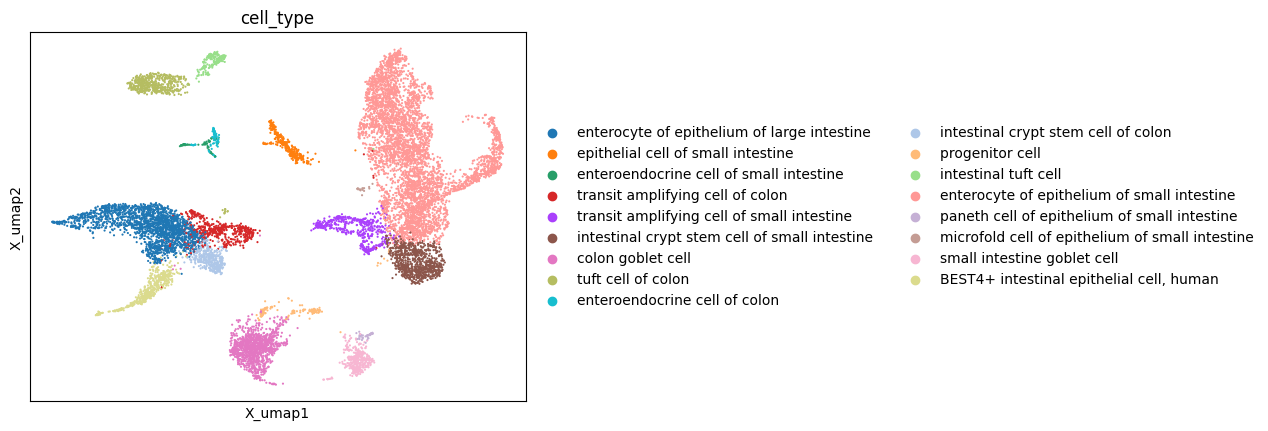

In [6]:
sc.pl.embedding(adata, basis="X_umap", color='cell_type')

In [8]:
adata.obs.drop(columns="is_primary_data", inplace=True)
preprocessor = Preprocessor(do_postp=False)
adata = preprocessor(adata)

Dropping layers:  KeysView(Layers with keys: true)
checking raw counts
removed 0 non primary cells, 51370 renamining
filtered out 0 cells, 51370 renamining
Removed 0 genes.
validating


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scdataloader/preprocess.py:248: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_utils.validate(adata, organism=adata.obs.organism_ontology_term_id[0])
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/lamindb/_can_validate.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(values[0], list):
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/lamindb/_can_validate.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated a

startin QC
Seeing 22953 outliers (44.68% of total dataset):
done


In [9]:
adata.layers['true'] = adata.X.copy()


## regular denoise

In [25]:
model.attn_bias = "none"# = "log"

In [10]:
adata

AnnData object with n_obs × n_vars = 12590 × 70933
    obs: 'hash_label', 'hash_cluster', 'n_genes', 'hashed', 'group', 'treatment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'pct_counts_hb', 'batch', 'S_score', 'G2M_score', 'phase', 'leiden', 'lineage', 'type', 'cds', 'donor_region', 'dpt_pseudotime', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'organism_ontology_term_id', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'suspension_type', 'BMI', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'nnz', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'outlier', 'mt_outlier', 'cell_culture'
    var: 

In [12]:
denoise = Denoiser(
    batch_size=10,
    max_len=5000,
    max_cells=10_000,
    doplot=False,
    num_workers=1,
    predict_depth_mult=10,
    downsample = 0.7,
    how="most var",
    dtype=torch.bfloat16,
)
metrics, idx, genes, expr = denoise(model, adata)
metrics

5000


100%|██████████| 1000/1000 [00:35<00:00, 28.12it/s]


{'reco2noisy': 0.7506823171196444,
 'reco2full': 0.5273230688797022,
 'noisy2full': 0.36814620672690057}

# aggregate with KNN

In [20]:
subadata = AnnData(X=expr, obs=adata.obs.iloc[idx], var=adata.var.loc[genes])

In [21]:
nadata = withknn(subadata, seed=42, k=10)

Performing kNN-smoothing v2.1 with k=10, d=10, and dither=0.030...
Step 1/4: Smooth using k=2
	PCA took 1.3 s.
	The fraction of variance explained by the top 10 PCs is 54.7 %.
	Calculating pair-wise distance matrix took 0.2 s.
	Calculating the smoothed expression matrix took 1.2 s.
Step 2/4: Smooth using k=4
	PCA took 0.8 s.
	The fraction of variance explained by the top 10 PCs is 64.9 %.
	Calculating pair-wise distance matrix took 0.1 s.
	Calculating the smoothed expression matrix took 0.9 s.
Step 3/4: Smooth using k=8
	PCA took 0.2 s.
	The fraction of variance explained by the top 10 PCs is 74.0 %.
	Calculating pair-wise distance matrix took 0.1 s.
	Calculating the smoothed expression matrix took 1.6 s.
Step 4/4: Smooth using k=10
	PCA took 0.2 s.
	The fraction of variance explained by the top 10 PCs is 81.4 %.
	Calculating pair-wise distance matrix took 0.1 s.
	Calculating the smoothed expression matrix took 1.0 s.
kNN-smoothing finished in 8.3 s.


In [22]:
reco = nadata.layers['denoised']
true = adata.X[idx][:, adata.var.index.isin(genes)].toarray()
noisy = np.loadtxt("collator_output.txt")
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.34047361142106214,
 'reco2full': 0.7191949298125354,
 'noisy2full': 0.3898535051640332}

# on random expr

In [ ]:
denoise = Denoiser(
    model,
    batch_size=40,
    max_len=2200,
    max_cells=5_000,
    doplot=False,
    predict_depth_mult=10,
    downsample = 0.7,
    how="random expr"
)
metrics, idx, genes, expr = denoise(adata)
metrics

100%|██████████| 125/125 [00:45<00:00,  2.72it/s]


{'reco2noisy': 0.7151437850641974,
 'reco2full': 0.3239858026438798,
 'noisy2full': 0.1896732525309344}

## with MAGIC

In [23]:
genes = torch.load(model_path, map_location=torch.device('cpu'))['hyper_parameters']['genes']
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=5000, span=0.99)

In [32]:
subadata = adata[:, adata.var.index.isin(genes) & adata.var.highly_variable].copy()
subadata.X = downsample_profile(torch.Tensor(subadata.X.toarray()), 0.7)


In [33]:
denoised_adata = sc.external.pp.magic(subadata.copy(), copy=True, n_jobs=10, solver='approximate', verbose=True)

Calculating MAGIC...
  Running MAGIC on 12590 cells and 3874 genes.
  Running MAGIC on 12590 cells and 3874 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.80 seconds.
    Calculating KNN search...
    Calculated KNN search in 6.99 seconds.
    Calculating affinities...
    Calculated affinities in 7.14 seconds.
  Calculated graph and diffusion operator in 16.96 seconds.
  Calculating imputation...
  Calculated imputation in 0.11 seconds.
Calculated MAGIC in 18.12 seconds.


In [34]:
reco = denoised_adata.X[idx]
true = subadata.layers['true'].toarray()[idx]
noisy = subadata.X[idx]
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.31479534784783636,
 'reco2full': 0.7667664378421589,
 'noisy2full': 0.38961157609044794}

## with MAGIC rare cells

In [30]:
ct = "microglial cell"
subadata
#microglial cell, microfold cell of epithelium of small intestine, mesangial cell, pericyte

AnnData object with n_obs × n_vars = 10000 × 3107
    obs: 'biosample_id', 'donor_id', 'cell_type_ontology_term_id', 'organism_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type__custom', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'is_primary_data', 'age', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'descr

In [169]:
reco = denoised_adata[subadata.obs.cell_type==ct].X
true = subadata[subadata.obs.cell_type==ct].layers['true'].toarray()
noisy = subadata[subadata.obs.cell_type==ct].X
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.16739547347403197,
 'reco2full': 0.40762284286749056,
 'noisy2full': 0.3610326755364074}

## same, with KNN

In [31]:
nadata = withknn(subadata, seed=42, k=10)

Performing kNN-smoothing v2.1 with k=10, d=10, and dither=0.030...

Step 1/4: Smooth using k=2
	PCA took 0.5 s.
	The fraction of variance explained by the top 10 PCs is 25.8 %.
	Calculating pair-wise distance matrix took 1.6 s.
	Calculating the smoothed expression matrix took 6.2 s.
Step 2/4: Smooth using k=4
	PCA took 0.4 s.
	The fraction of variance explained by the top 10 PCs is 35.0 %.
	Calculating pair-wise distance matrix took 1.5 s.
	Calculating the smoothed expression matrix took 6.2 s.
Step 3/4: Smooth using k=8
	PCA took 0.4 s.
	The fraction of variance explained by the top 10 PCs is 46.9 %.
	Calculating pair-wise distance matrix took 1.5 s.
	Calculating the smoothed expression matrix took 6.3 s.
Step 4/4: Smooth using k=10
	PCA took 0.4 s.
	The fraction of variance explained by the top 10 PCs is 59.5 %.
	Calculating pair-wise distance matrix took 1.5 s.
	Calculating the smoothed expression matrix took 6.3 s.
kNN-smoothing finished in 33.6 s.


In [32]:
reco = nadata.layers['denoised']#.toarray()
true = subadata.layers['true'].toarray()
noisy = subadata.X
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.41386242619767566,
 'reco2full': 0.5781715062761915,
 'noisy2full': 0.3685645948380719}

## with KNN rare cells

In [33]:
reco = nadata.layers['denoised'][nadata.obs.cell_type==ct]
true = subadata[subadata.obs.cell_type==ct].layers['true'].toarray()
noisy = subadata[subadata.obs.cell_type==ct].X
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.44956156837292166,
 'reco2full': 0.5479113692785387,
 'noisy2full': 0.3724976804482466}

## MAGIC Rare cell without support

In [170]:
subadata = adata[adata.obs.cell_type==ct, adata.var.index.isin(genes)]
sc.pp.highly_variable_genes(
    subadata, flavor="seurat_v3", n_top_genes=5000, span=0.99)

In [171]:
subadata.X = downsample_profile(torch.Tensor(subadata.X.toarray()), 0.7)

In [172]:
denoised_adata = sc.external.pp.magic(subadata[:,subadata.var.highly_variable][:30], knn=5, n_jobs=20, solver='approximate', copy=True)

/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:650: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("MAGIC"):
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:381: DeprecationWarning: Call to deprecated method info. (Use TaskLogger.log_info instead) -- Deprecated since version 1.1.0.
  _logger.info(
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:436: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("graph and diffusion operator"):
/home/ml4ig1/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 100 dimensions on data with min(n_samples, n_features) = 30
  warnings.warn(
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:748: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_ta

In [173]:
reco = denoised_adata.X
true = subadata[subadata.obs.cell_type==ct, subadata.var.highly_variable].layers['true'][:30].toarray()
noisy = subadata[subadata.obs.cell_type==ct, subadata.var.highly_variable][:30].X
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.3116307487080801,
 'reco2full': 0.4477594810317442,
 'noisy2full': 0.3117786337560895}

## scPRINT rare cells

In [ ]:
denoise = Denoiser(
    model,
    batch_size=40,
    max_len=5000,
    max_cells=30,
    doplot=False,
    predict_depth_mult=10,
    downsample = 0.7,
    how="most var"
)
metrics, idx, genes, expr = denoise(adata[adata.obs.cell_type==ct])
metrics

5000


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


{'reco2noisy': 0.7122362370625847,
 'reco2full': 0.3170816393649402,
 'noisy2full': 0.20527492811994658}